# Conditional Generative Adversarial Network (CGAN)

## Import Modules

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import imageio
from IPython.display import clear_output

## Conditional GAN (Model) 

In [2]:
class ConditionalGAN(tf.keras.Model):
  def __init__(self, noise_dim, gen_lr=1e-4, disc_lr=1e-4):
    super(ConditionalGAN, self).__init__()
    self.noise_dim = noise_dim
    self.cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.generator_optimizer = tf.keras.optimizers.Adam(lr=gen_lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=disc_lr)

    self.generator = tf.keras.Sequential([
      tf.keras.layers.Dense(7 * 7 * 255, use_bias=False, input_shape=(noise_dim,)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Reshape((7, 7, 255)),
      tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ], name='Generator')
    
    self.discriminator = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1)
    ], name='Discriminator')

  def generate_fake_images(self, training=True, n_samples=100, noise=None):
    if noise is None:
      noise = tf.random.normal((n_samples, self.noise_dim))
    return self.generator(noise, training=training)

  def discriminator_loss(self, real_images):
    fake_images = self.generate_fake_images(n_samples=100, training=False)

    real_output = self.discriminator(real_images)
    fake_output = self.discriminator(fake_images)
    
    real_loss = self.cross_entropy_loss(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy_loss(tf.zeros_like(fake_output), fake_output)

    return (real_loss + fake_loss) / 2

  def generator_loss(self):
    fake_images = self.generate_fake_images(n_samples=100, training=True)
    fake_output = self.discriminator(fake_images, training=False)
    return self.cross_entropy_loss(tf.ones_like(fake_output), fake_output)

  @tf.function
  def train_step(self, real_images):
    with tf.GradientTape() as gen_tape:
      gen_loss = self.generator_loss()
    
    with tf.GradientTape() as disc_tape:
      disc_loss = self.discriminator_loss(real_images)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

    self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    return gen_loss, disc_loss

  def save(self, fname=None):
    if fname:
      self.discriminator.save_weights(f'{fname}-discriminator.h5')
      self.generator.save_weights(f'{fname}-generator.h5')
    else:
      self.discriminator.save_weights('discriminator.h5')
      self.generator.save_weights('generator.h5')
  
  def load(self, fname=None):
    if fname:
      self.discriminator.load_weights(f'{fname}-discriminator.h5')
      self.generator.load_weights(f'{fname}-generator.h5')
    else:
      self.discriminator.load_weights('discriminator.h5')
      self.generator.load_weights('generator.h5')

## Utill Functions

In [13]:
def generate_and_save_images(model, epoch, noise, save_img=False, folder='images'):
  if not os.path.exists(folder):
    os.mkdir(folder)
  
  fake_images = model.generate_fake_images(training=False, noise=noise)
  fig = plt.figure(figsize=(8, 8))

  for i in range(fake_images.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(fake_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save_img:
    plt.savefig(f'{folder}/{folder}_{epoch:03d}.png')
  plt.show()


def generate_gif(anim_file='cgan.gif', folder='images'):
  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = os.listdir(folder)
    for filename in filenames:
      image = imageio.imread(os.path.join(folder, filename))
      writer.append_data(image)
    image = imageio.imread(os.path.join(folder, filename))
    writer.append_data(image)

## Model Summaries

In [4]:
cgan = ConditionalGAN(100)
cgan.generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12495)             1249500   
_________________________________________________________________
batch_normalization (BatchNo (None, 12495)             49980     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12495)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 255)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         816000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

In [5]:
cgan.discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

## Load Data

In [6]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
y_train = y_train.reshape(-1, 1)
n_samples = x_train.shape[0]

x_train = (x_train - 127.5) / 127.5

train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(n_samples).batch(256)

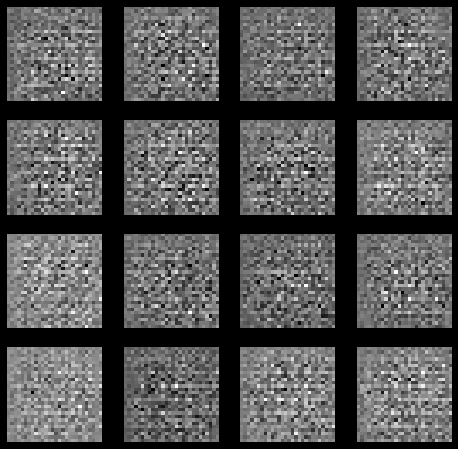

In [7]:
cgan = ConditionalGAN(noise_dim=100)
tf.random.set_seed(0)
noise_for_images_during_training = tf.random.normal((16, 100))

n_epochs = 100
n_batches = len(train_data)
generate_and_save_images(cgan, 0, noise=noise_for_images_during_training, save_img=True)

Epoch: 100/100  Batch:  225/235  gen_loss:  1.12166  disc_loss:  0.59456


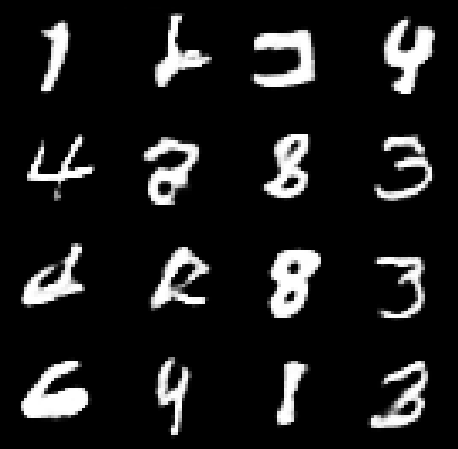

In [8]:
for epoch in range(1, n_epochs + 1):
  for i, (real_images) in enumerate(train_data):
    gen_loss, disc_loss = cgan.train_step(real_images)

    if (i + 1) % 25 == 0 or (i + 1) == n_batches:
      clear_output(wait=True)
      print(f'Epoch: {epoch: >2}/{n_epochs}  Batch: {i + 1: >4}/{n_batches}  gen_loss: {gen_loss: .5f}  disc_loss: {disc_loss: .5f}')
      generate_and_save_images(cgan, epoch, noise_for_images_during_training, save_img=(epoch % 5 == 0))

In [14]:
generate_gif()

In [11]:
cgan.save()